In [1]:
import mosfit
import numpy as np
import time
import swyft

import astropy.cosmology as cosmo
import astropy.units as u

from astropy.cosmology import z_at_value
from gwtoolbox import tools_earth
from scipy.stats import truncnorm

**Utility Methods**

In [2]:
def jansky(mab):
    return 10**((8.9-mab)/2.5)

**Class Methods and Features**

*Gravitational Wave Generator*

In [3]:
def gwtoolbox_gen(H0_true):
    Om0 = 0.31
    T0 = 2.725
    # generate desired cosmology
    cosmos = tools_earth.set_cosmology(None, H0_true, Om0, T0)
    # R0, tau, m_mean, m_sclae, m_low, m_high, chi_sigma
    # R0: merger rate [/yr/Gpc3] 
    # tau: Delay time from formation to merger [Gyr]
    # mass mean, standard deviation, low, high [solar masses]
    # dispersion of effective spin
    # be sure to keep these consistent with MOSFIT!
    # find sauce to motivate the selected values
    BNS_par = [300,3,1.4,0.5,1.1,2.5,0.1]
    # summon the desired tool (LIGO)
    Tools = tools_earth.Tools(detector_type='ligo', event_type='nsns',\
                              population=BNS_par, cosmos=cosmos)
    # set generator parameters
    time_obs = 60*24*365 # units of minutes of observation
    rho_cri = 8 # signal-to-noise ratio cutoff
    tot_num = Tools.total_number(time_obs, rho_cri)
    # returns keys 'z','D','m1','m2','χ','dz','dm1','dm2','dχ','dD','dtb'
    list_det = Tools.list_with_errors_df(time_obs, rho_cri, dtp=True)
    params = [list_det['z'], list_det['D'], list_det['m1'], list_det['m2'],\
              list_det['χ'], list_det['dz'], list_det['dm1'], list_det['dm2'],\
              list_det['dχ'], list_det['dD'], list_det['dtb']]
    return params

I will want to turn this into a one-off O4 generator as follows: 
1. Generate all 20-something gravitational waves for one year
2. determine the fraction which have GW detections
3. use mosfit to determine the fraction which have EM detections

For the time being, let us take a single event and run our forward model for this event

In [4]:
o4_all = gwtoolbox_gen(70)

In [5]:
# z, DL, m1, m2, etc...
single_event = np.array(o4_all).T[0]

In [12]:
single_event

array([7.72063605e-02, 3.49698509e+02, 1.96132640e+00, 1.41396710e+00,
       2.37410262e-01, 3.86031803e-02, 9.80663198e-02, 7.06983552e-02,
       3.62016785e-04, 1.84098413e+02, 6.60000000e-02])

At this stage, I sample all of my favorite parameters from their priors. In the baby model, I will only sample $H_0$ and $v$, while leaving all other parameters fixed.

Rather than using GWToolBox for now, I'm going to create some very simple kilonovae from scratch and create a method to determine whether or not they were detected.

**Generating True Events from Scratch**

The idea here is to have two events at exactly the same distance. The only thing which will distinguish between them is their inclination angle

In [4]:
# assume a true value for the Hubble constant
u_true = cosmo.FlatLambdaCDM(70, 0.27)
# set the true redshift of the events
z_true = 0.031
# calculate the true distance of the events
d_true = u_true.luminosity_distance(z_true).value
m1_true = 1.4
m2_true = 1.4

In [5]:
# z, dl, m1, m2, v
# event_list = [[z_true, d_true, m1_true, m2_true, 0.1, False],[z_true, d_true, m1_true, m2_true, 0.9, True]]
# let's leave two events for later due to the complications of observed and unobserved events being put together
event_list = [[z_true, d_true, m1_true, m2_true, 0.1, False]]
det_obs = [False]

In [6]:
[False, False] == [False, False]

True

In [7]:
# I am still unsure as to the effect of the limiting magnitude here, besides setting a cutoff

my_fitter = mosfit.fitter.Fitter(quiet=False, test=True, offline=False)
# my_fitter = mosfit.fitter.Fitter(limiting_magnitude=23.3, quiet=False, test=True, offline=False)

In [8]:
fixed_params = {"ebv": 2.2, "rvhost": 3.1, "frad": 0.999, "nnhost": 1e18,\
              "texplosion": -0.01, "temperature": 2500, "kappa_red": 10,\
              "kappa_blue": 0.5, "kappagamma": 10000.0, "Mchirp": 1.188,\
              "q": 0.92, "cos_theta": 0.5, "cos_theta_open": 0.707107,\
              "disk_frac": 0.15, "radius_ns": 11.0, "alpha": 1.0,\
              "Mtov": 2.2, "cos_theta_cocoon": 0.5, "tshock": 1.7,\
              "temperature_shock": 100, "lumdist": 400, "redshift": 0.9}
              
# ebv: host galaxy extinction, sampled from RA/DEC
# rvhost: host galaxy extinction (?)
# frad: no idea
# nnhost: no idea
# texplosion: when the explosion occurs (?)
# temperature: surface temperature of NS (?)
# kappa_red: no idea
# kappa_blue: no idea
# kappagamma: no idea
# Mchirp: the chirp mass
# q: M1/M2 ratio
# cos_theta: orientation angle
# cos_theta_open: no idea
# disk_frac: no idea
# radius_ns: radius of NS (?)
# alpha: no idea
# Mtov: no idea
# cos_theta_cocoon: no idea
# tshock: time of shock (?)
# temperature_shock: temperature of shock (?)

In [9]:
def light_curve(fitfunc, fixed_params):
    """
    Given a fit function and a list of fixed parameters, generates a light curve using mosfit 
    and returns whether a detection is made.
    args:
    - fixed_params: dictionary of fixed parameters
    returns:
    - detection: bool
    
    To do: this should also take the observing time window in units of days after the explosion,
    the magnitude cutoff of each observing band, and probably something else.
    """
    # convert dictionary to list
    # consider turning this into a utility function
    fpar = ["ebv", fixed_params['ebv'], "rvhost", fixed_params['rvhost'],\
            "frad", fixed_params['frad'], "nnhost", fixed_params['nnhost'],\
            "texplosion", fixed_params['texplosion'],\
            "temperature", fixed_params['temperature'],\
            "kappa_red", fixed_params['kappa_red'],\
            "kappa_blue", fixed_params['kappa_blue'],\
            "kappagamma", fixed_params['kappagamma'],\
            "Mchirp", fixed_params['Mchirp'],\
            "q", fixed_params['q'], "cos_theta", fixed_params['cos_theta'],\
            "cos_theta_open", fixed_params['cos_theta_open'],\
            "disk_frac", fixed_params['disk_frac'],\
            "radius_ns", fixed_params['radius_ns'],\
            "alpha", fixed_params['alpha'], "Mtov", fixed_params['Mtov'],\
            "cos_theta_cocoon", fixed_params['cos_theta_cocoon'],\
            "tshock", fixed_params['tshock'], "temperature_shock",\
            fixed_params['temperature_shock'],\
            "lumdist", fixed_params['lumdist'], "redshift", fixed_params['redshift']]
    # create kwargs dict using fixed_params
    kwargs = dict(events=[], models=['bns_generative'],\
              max_time=4, band_list="z", band_systems="AB", iterations=0, num_walkers=1,\
              smooth_times=4, suffix="jupyter_test", user_fixed_parameters=fpar,\
             quiet=True)
    # run mosfit
    entries, ps, lnprobs = my_fitter.fit_events(**kwargs)
    # get observed magnitudes
    # see if there is any way to do this without a for loop
    obs_mags = []
    for entry in entries[0][0]['photometry']:
        if entry['system'] == 'AB':
            obs_mags += [float(entry['magnitude'])]
    print(obs_mags)
    # magnitude probability of detection
    sig10 = 23.3
#     mclip_a = 0
#     mclip_b = 100
#     m_std = abs((jansky(sig10)) / 10)
#     a, b = mclip_a / m_std, mclip_b / m_std
#     v = truncnorm(a,b)
#     # see if the lowest magnitude beats our probabilistic detection threshold
#     flux_obs = jansky(np.array(obs_mags))
#     obs_probs = v.cdf(flux_obs/m_std)
#     mprob = np.random.uniform(0,1)
#     detect = mprob < obs_probs
    detect = min(obs_mags) <= sig10
#     return True in detect
    return detect

In [10]:
# set simulator parameters
DEVICE = 'cpu'  # replace with 'cpu' if no GPU is available
Ntrain = 10
Npar = 2

In [35]:
def forward(v):
    # get terms from input vector
    H0 = v[0]
    v0 = np.cos(v[1])
    det_list = []
    for event in event_list:
        print(event)
        # use results from GWToolbox to get the true DL, M1, M2
        TDL = event[1]
        M1 = event[2]
        M2 = event[3]
        # derived mass quantities
        Q = M1/M2
        Mchirp = ((M1*M2)**3/(M1+M2))**(1/5)
        # create a cosmology from H0 and generate the true redshift
        # in this sample cosmology
        # assume omega_m=0.31 (make sure this is consistent with GWTB)
        universe = cosmo.FlatLambdaCDM(H0, 0.31)
        # "z in cosmology"
        ZIC = z_at_value(universe.luminosity_distance, TDL*u.Mpc)
        fixed_params = {"ebv": 2.2, "rvhost": 3.1, "frad": 0.999, "nnhost": 1e18,\
                  "texplosion": -0.01, "temperature": 2500, "kappa_red": 10,\
                  "kappa_blue": 0.5, "kappagamma": 10000.0, "Mchirp": Mchirp,\
                  "q": Q, "cos_theta": v0, "cos_theta_open": 0.707107,\
                  "disk_frac": 0.15, "radius_ns": 11.0, "alpha": 1.0,\
                  "Mtov": 2.2, "cos_theta_cocoon": 0.5, "tshock": 1.7,\
                  "temperature_shock": 100, "lumdist": TDL, "redshift": ZIC}
        det = light_curve(my_fitter, fixed_params)
        det_list += [det]
    if det_list == det_obs:
        x = [1.0]*Npar
    else:
        x = [0.0]*Npar
    return dict(x=x)

In [14]:
forward([80, np.pi/2*(0.9)])

[0.031, 136.01490866174305, 1.4, 1.4, 0.1, False]

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdi

{'x': [0.0, 0.0]}

**Congratulations!**
You now have a working forward model! With the data you've given it, it is only informative for priors which stretch beyond $h=0.8$, so let's make sure to define a broad prior.

Let's see if my simulator is the problem by writing in a simple model

In [32]:
def model(v):
    if sum(v) < 0.5:
        x = np.array([1]*Npar)
    else:
        x = np.array([0]*Npar)
    return dict(x=x)

In [36]:
# a TMNRE prior function take a random variable between 0 and 1 and produces an input vector from a prior of your choice

Ntrain = 20

def pfunc(u):
    H0 = 50 * u[0] + 50
#     v = np.cos(np.pi / 2 * u[1])
    theta = np.pi / 2 * u[1]
    return np.array([H0, theta])

In [43]:
# simulator = swyft.Simulator(simulator, Npar, sim_shapes = {"x": [Npar]})
# store = swyft.MemoryStore(simulator)

simulator = swyft.Simulator(forward, ["H_0", "\theta"], sim_shapes = {"x": [Npar]})
store = swyft.MemoryStore(simulator)

prior = swyft.Prior(pfunc, Npar)
# prior = swyft.Prior(lambda u: u*50+50, Npar)
store.add(Ntrain, prior)
store.simulate()

Creating new store.
Store: Adding 17 new samples to simulator store.
[0.031, 136.01490866174305, 1.4, 1.4, 0.1, False]

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mt


Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walker


Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

L


Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
[28.138157778804977, 23.199154896637282, 23.691639283285326, 24.015760769908212]
[0.031, 136.01490866174305,


Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `tempe

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

L

In [24]:
dataset.__getitem__(3)

({'x': tensor([0., 0.])}, tensor([0.5193, 0.8907]), tensor([75.9666, 94.5353]))

In [54]:
dataset = swyft.Dataset(Ntrain, prior, store)
post = swyft.Posteriors(dataset)

In [55]:
post.add([(0, 1)], device=DEVICE)
post.train([(0, 1)], max_epochs = 20, nworkers=0)

Training: lr=0.001, Epoch=6, VL=1.362


In [56]:
v0 = np.zeros(Npar)
obs0 = model(v0)

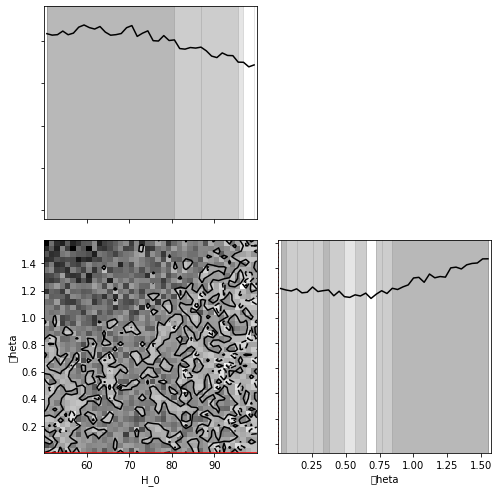

In [58]:
samples = post.sample(100000, obs0)
swyft.plot_corner(samples, [0, 1], color='k', figsize = (8,8), truth=v0, bins = 40);